In [467]:
from sklearn import linear_model  
from sklearn.linear_model import LinearRegression  
import csv          
import requests     
import numpy as np  
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics

# Part 1 – Pre-processing/Exploring the data:

## Predictive maintance dataset

The following dataset is a synthetic dataset that reflects real predictive maintenance encountered in the industry. It consists of 10 000 datapoints across 14 different features. This dataset is licenced under CC0 1.0, public domain.

1: UID: unique identifier ranging from 1 to 10000

2: productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

3: air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

4: process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

5: rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise

6: torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

7: tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

8: tool wear failure (TWF) : the tool will be replaced or fail at a randomly selected tool wear time between 200 – 240 mins (120 times in our dataset). At this point in time, the tool is replaced 74 times, and fails 46 times (randomly assigned).

9: heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool’s rotational speed is below 1380 rpm. This is the case for 115 data points.

10: power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

11: overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 for M, 13,000 for H), the process fails due to overstrain. This is true for 98 datapoints.

12:  random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for 19 datapoints, more frequent than could be expected for 10,000 datapoints in our dataset.


S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), Irvine, CA, USA, 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.





In [468]:
#Importing the csv file and reading it
myDataSet = pd.read_csv("ai4i2020.csv")

In [469]:
myDataSet.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


As you can see there are two indexing types, both the UDI(unique identifier) and Product ID, i will drop these in the following analysis. We have one ordinal categorical feature, "Type", and the rest are quantitative

In [470]:
#Next we check for duplicate columns
myDataSet[(myDataSet.duplicated())]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


This shows that there are no duplicate rows in the dataset.

Next we check the statistic information of our dataset


In [471]:
myDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [472]:
myDataSet.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


The mean is particularly affected by outliers, as it is calculated using the average value of the feature. The median is calculated using the middle value in the set, and is therefore not so affected by outliers. If there is a big difference between the mean and the median it could indicate that the dataset has a lot of outliers. Looking at the difference between the median and mean in the table above, we see that for the applicable features, the difference is very low, which indicates that the dataset has a small amount of outliers.

array([[<AxesSubplot:title={'center':'UDI'}>,
        <AxesSubplot:title={'center':'Air temperature [K]'}>,
        <AxesSubplot:title={'center':'Process temperature [K]'}>],
       [<AxesSubplot:title={'center':'Rotational speed [rpm]'}>,
        <AxesSubplot:title={'center':'Torque [Nm]'}>,
        <AxesSubplot:title={'center':'Tool wear [min]'}>],
       [<AxesSubplot:title={'center':'Machine failure'}>,
        <AxesSubplot:title={'center':'TWF'}>,
        <AxesSubplot:title={'center':'HDF'}>],
       [<AxesSubplot:title={'center':'PWF'}>,
        <AxesSubplot:title={'center':'OSF'}>,
        <AxesSubplot:title={'center':'RNF'}>]], dtype=object)

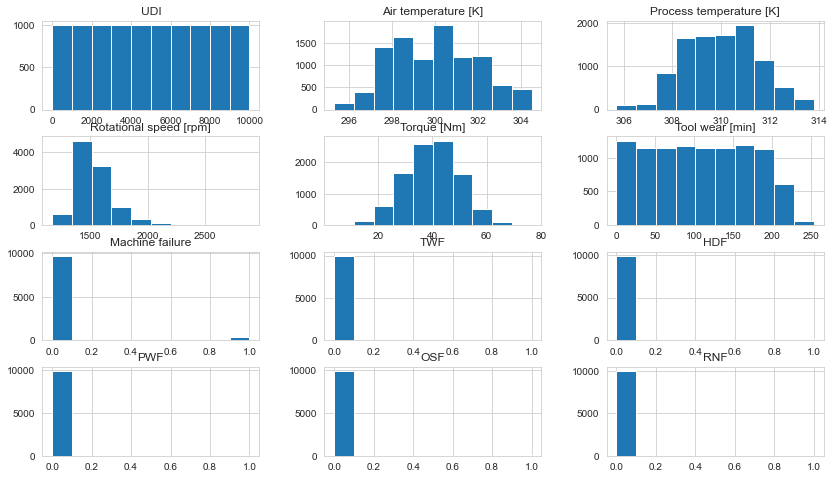

In [473]:
myDataSet.hist(figsize=(14,8))

We see that the different error types are very much underrepresented. Going forward only the "Machine failure" feature, which includes all the different error types, will be used.

In [474]:
print(myDataSet['Type'].value_counts())

L    6000
M    2997
H    1003
Name: Type, dtype: int64


Looking at the catagorical value "Type", we see that the low quality milling bits are overrepresented, and the medium and high quality are underrepresented

In [475]:
#Transforming the catagorical values into numerical ones, L = 0, M = 1, H = 2

myDataSet['Type'].replace('L', 0, inplace=True)
myDataSet['Type'].replace('M', 1, inplace=True)
myDataSet['Type'].replace('H', 2, inplace=True)

In [476]:
# Define the working dataset without indexing and error features

workingDataSet = myDataSet[["Type", "Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Tool wear [min]","Machine failure"]]

# Next we check for any missing values
# workingDataSet.info()

Now we see in our working dataset, that there are no null-values, and the catagorical feature values has been converted sucessfully. We might have to drop the "Type" feature, given that it is so unbalanced, but this will be answered on further analasis

Data normalization of all the range based numerical data can improve model performance, convergence, 
and prevents numerical instability

In [477]:
# DATA NORMALIZATION

workingDataSet["Air temperature [K]"]=(workingDataSet['Air temperature [K]']-workingDataSet['Air temperature [K]'].min())/(workingDataSet['Air temperature [K]'].max()-workingDataSet['Air temperature [K]'].min())

workingDataSet["Process temperature [K]"]=(workingDataSet['Process temperature [K]']-workingDataSet['Process temperature [K]'].min())/(workingDataSet['Process temperature [K]'].max()-workingDataSet['Process temperature [K]'].min())

workingDataSet["Rotational speed [rpm]"]=(workingDataSet['Rotational speed [rpm]']-workingDataSet['Rotational speed [rpm]'].min())/(workingDataSet['Rotational speed [rpm]'].max()-workingDataSet['Rotational speed [rpm]'].min())

workingDataSet["Torque [Nm]"]=(workingDataSet['Torque [Nm]']-workingDataSet['Torque [Nm]'].min())/(workingDataSet['Torque [Nm]'].max()-workingDataSet['Torque [Nm]'].min())

workingDataSet["Tool wear [min]"]=(workingDataSet['Tool wear [min]']-workingDataSet['Tool wear [min]'].min())/(workingDataSet['Tool wear [min]'].max()-workingDataSet['Tool wear [min]'].min())

print(workingDataSet.head(10))
print(workingDataSet.describe())

# The output shows successful normalization 

   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     1             0.304348                 0.358025                0.222934   
1     0             0.315217                 0.370370                0.139697   
2     0             0.304348                 0.345679                0.192084   
3     0             0.315217                 0.358025                0.154249   
4     0             0.315217                 0.370370                0.139697   
5     1             0.304348                 0.358025                0.149593   
6     0             0.304348                 0.358025                0.227008   
7     0             0.304348                 0.358025                0.208964   
8     1             0.326087                 0.370370                0.290454   
9     1             0.347826                 0.407407                0.333527   

   Torque [Nm]  Tool wear [min]  Machine failure  
0     0.535714         0.000000                0  
1     

C:\Users\morte\AppData\Local\Temp\ipykernel_12132\1465001550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workingDataSet["Air temperature [K]"]=(workingDataSet['Air temperature [K]']-workingDataSet['Air temperature [K]'].min())/(workingDataSet['Air temperature [K]'].max()-workingDataSet['Air temperature [K]'].min())
C:\Users\morte\AppData\Local\Temp\ipykernel_12132\1465001550.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workingDataSet["Process temperature [K]"]=(workingDataSet['Process tempera

<AxesSubplot:>

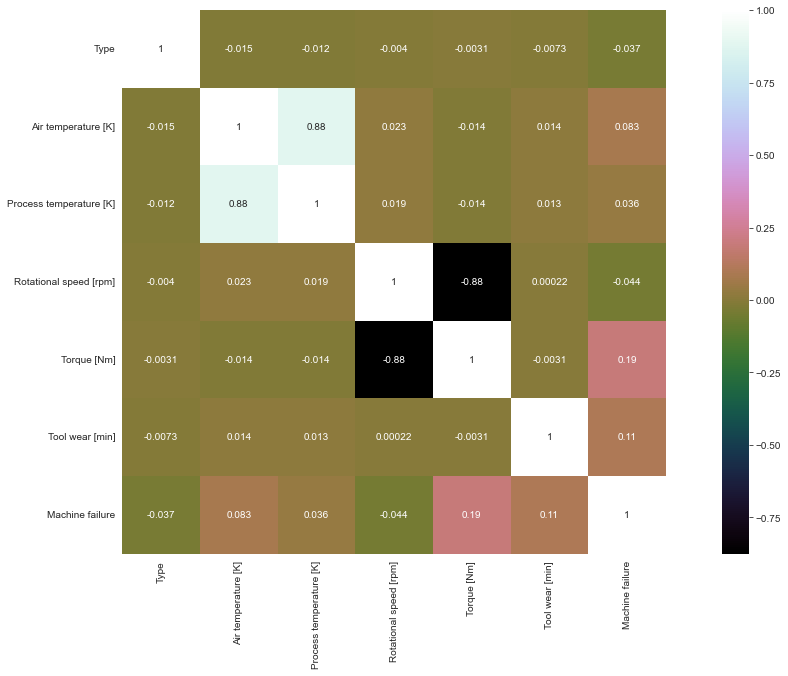

In [478]:
#We make a heat map to look for correlation between our features

my_correlation_matrix=workingDataSet.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(my_correlation_matrix,vmax=1,square=True,annot=True,cmap='cubehelix')

## Correlations

As shown in the correlation matrix, we see that:
* Rotational speed and torque has a strong negative correlation
* Process temperature and air temperature has a strong positive correlation
* there might be a small correlation between torque and machine failure
* there might be a small correlation between tool wear and machine failure

This means that the strong correlation between process and air temperature, and torque and RPM may affect our future classification algorithms. One could argue that removing either air or process temp would be beneficial for the model performance, due to the high correlation, same goes for torque and RPM.

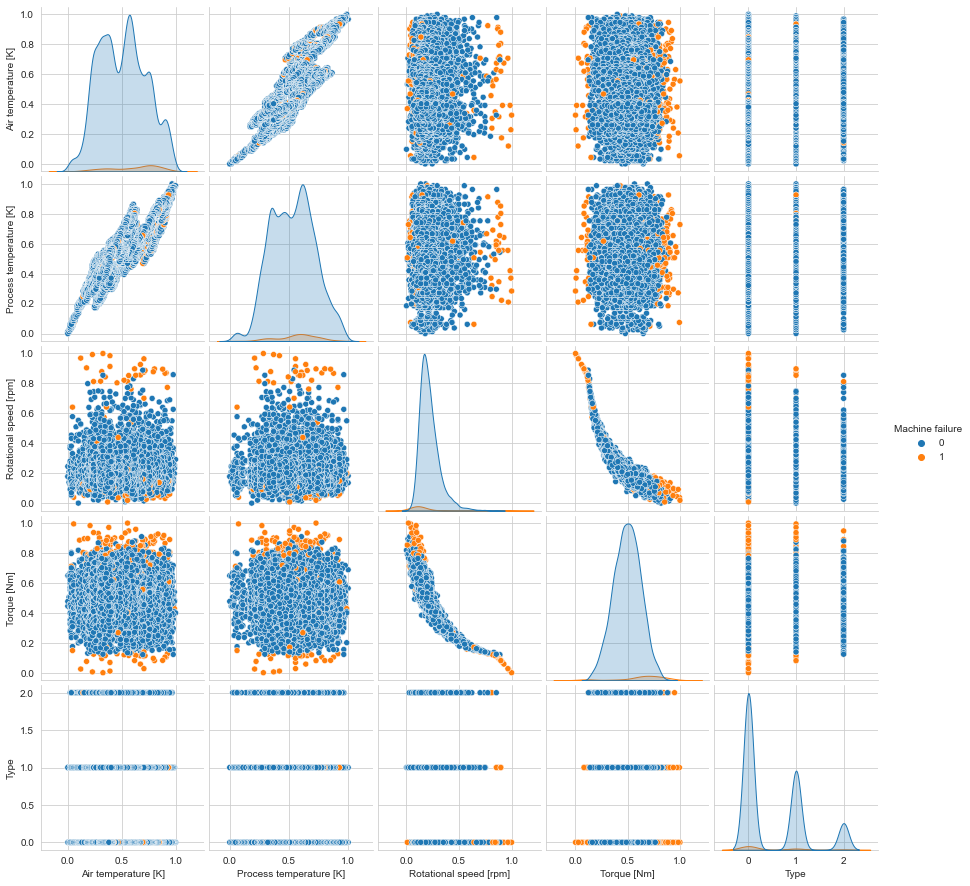

In [502]:
#Pairplot

my_pairplot = sns.pairplot(workingDataSet,hue='Machine failure',vars=["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Type"],kind='scatter')

## Pairplot analysis

A lot of information is given by the pairplot. The highlighted orange dots are the data points where an error has occured. Looking at this we can find where the errors are clustered, and therefore find out correlations between our features and error clusters.

Overall, there is quite bad clustering among our features, but some error clusters can be spotted.

* At the extreme ranges of both RPM and Torque there is error clustering
* At low RPM and high air temperature there is a small error cluster
* at low RPM and high torque there is a small error cluster
* At high torque and high air temperature there is a small error cluster

For eventual clustering tasks, one can assume that smaller clusters outside of a bigger cluster could indicate ranges where failure is likely.


# Logistic regression



In [479]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = workingDataSet.iloc[:,:-1] #This stores the features in X
y = workingDataSet.iloc[:,-1] #This stores the label in y

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, # test size is 20% of dataset
                                                    random_state = 0,
                                                    stratify=y)


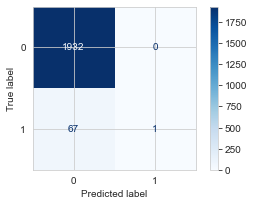

In [480]:
from sklearn.linear_model import LogisticRegression
logRegModel = LogisticRegression().fit(X_train,y_train)
y_predictions = logRegModel.predict(X_test) # These are the predictions from the test data.
#plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,logRegModel.predict(X_test))).plot(cmap=plt.cm.Blues)

# k-Nearest Neighbour (kNN)

kNN can be used for logistic classification.For this algorithm we must find the hyperparameter k.K is the number of nearest data objects that will be considered to identify the output value of the new data object.Considering we are using it for binary classification, the k value should be an odd number to negate the possibility of having an even number different features.

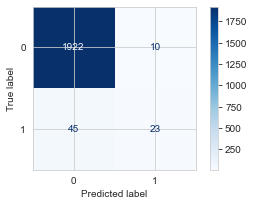

In [481]:
from sklearn.neighbors import KNeighborsClassifier

knnModel3 = KNeighborsClassifier(n_neighbors=3)
knnModel3.fit(X_train, y_train)d

#plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,knnModel3.predict(X_test))).plot(cmap=plt.cm.Blues)

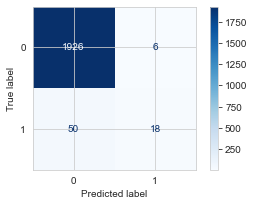

In [482]:
knnModel5 = KNeighborsClassifier(n_neighbors=5)
knnModel5.fit(X_train, y_train)
#plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,knnModel5.predict(X_test))).plot(cmap=plt.cm.Blues)

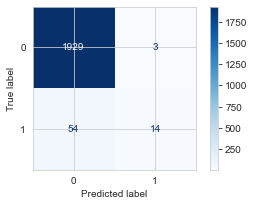

In [483]:
knnModel7 = KNeighborsClassifier(n_neighbors=7)
knnModel7.fit(X_train, y_train)
#plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test,knnModel7.predict(X_test))).plot(cmap=plt.cm.Blues)

# Unsupervised Learning

In unsupervised learning we do not give our models the labels of our features, and it tries through grouping to find patterns. For the unsupervised learning i will use DBScan and other one 


The first to do is agglomerative hierarical clustering.

Clustering has a couple of hyperparameters. minPts, or the minimum amount of samples in a cluster. And the maximum distance between data points where they can be considered neighbours, in a radius around the datapoint. often denoted as epsilon

There are different methods of defining the hyper parameters. Epsilon can be found using a k-distance graph. Plot the average distance by a sorted list of distance between datapoints.


## ward

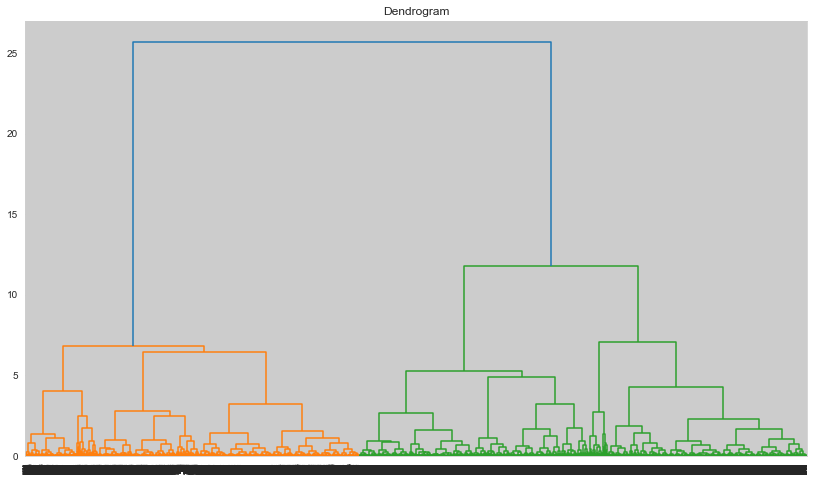

In [525]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

clusteringDataset = workingDataSet[["Rotational speed [rpm]","Air temperature [K]"]]
clustering = AgglomerativeClustering(linkage='ward').fit(clusteringDataset)

plt.figure(figsize =(14, 8))
plt.title('Dendrogram')
Dendrogram = sch.dendrogram(sch.linkage(clusteringDataset, method='ward', metric='euclidean'))
plt.show()


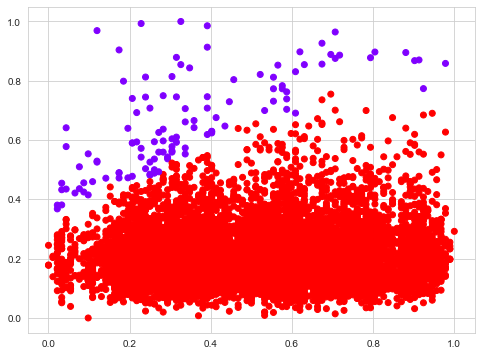

In [534]:
aggl_clust_ward = AgglomerativeClustering(n_clusters = 2)
# Visualizing the clustering
plt.figure(figsize =(8, 6))
plt.scatter(clusteringDataset['Air temperature [K]'], clusteringDataset['Rotational speed [rpm]'], 
           c = clustering.fit_predict(clusteringDataset), cmap ='rainbow')
plt.show()

## complete-linkage

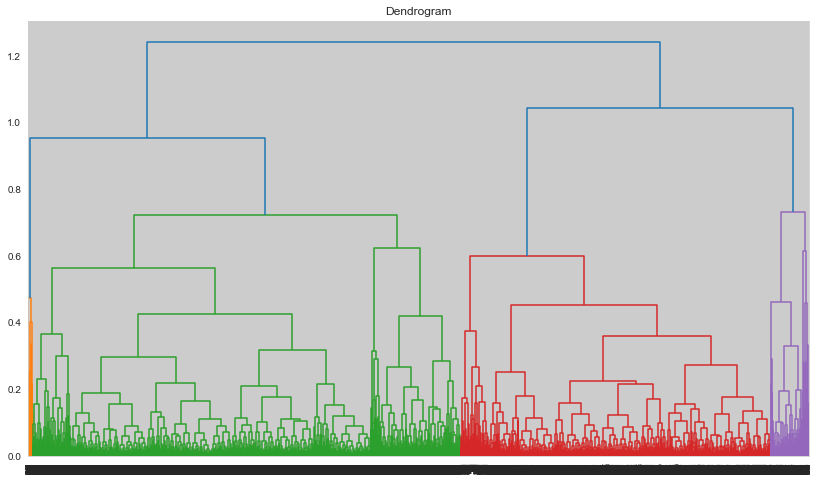

In [531]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

clusteringDataset = workingDataSet[["Rotational speed [rpm]","Air temperature [K]"]]
clusteringComplete = AgglomerativeClustering(linkage='complete').fit(clusteringDataset)

plt.figure(figsize =(14, 8))
plt.title('Dendrogram')
Dendrogram = sch.dendrogram(sch.linkage(clusteringDataset, method='complete', metric='euclidean'))
plt.show()


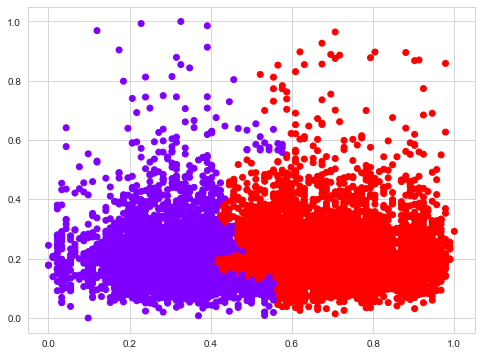

In [532]:
aggl_clust_complete = AgglomerativeClustering(n_clusters = 2)
# Visualizing the clustering
plt.figure(figsize =(8, 6))
plt.scatter(clusteringDataset['Air temperature [K]'], clusteringDataset['Rotational speed [rpm]'], 
           c = clusteringComplete.fit_predict(clusteringDataset), cmap ='rainbow')
plt.show()

## Average linkage

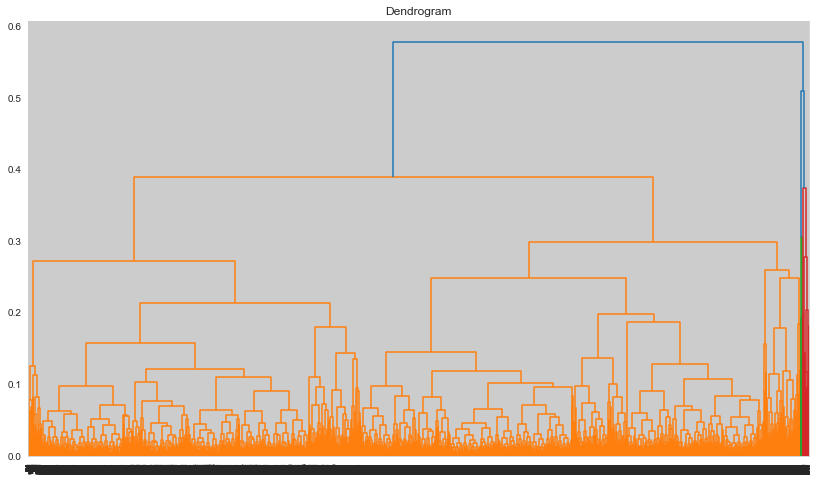

In [530]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

clusteringDataset = workingDataSet[["Rotational speed [rpm]","Air temperature [K]"]]
clusteringAverage = AgglomerativeClustering(linkage='average').fit(clusteringDataset)

plt.figure(figsize =(14, 8))
plt.title('Dendrogram')
Dendrogram = sch.dendrogram(sch.linkage(clusteringDataset, method='average'))
plt.show()


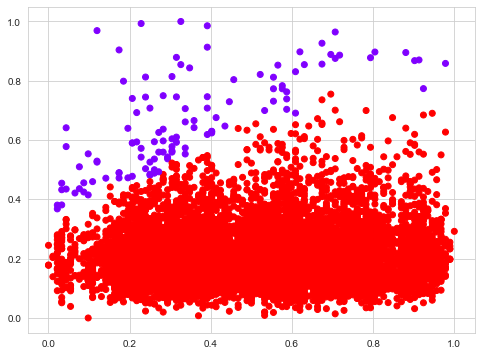

In [533]:
aggl_clust_complete = AgglomerativeClustering(n_clusters = 2)
# Visualizing the clustering
plt.figure(figsize =(8, 6))
plt.scatter(clusteringDataset['Air temperature [K]'], clusteringDataset['Rotational speed [rpm]'], 
           c = clusteringAverage.fit_predict(clusteringDataset), cmap ='rainbow')
plt.show()

## DBSCAN

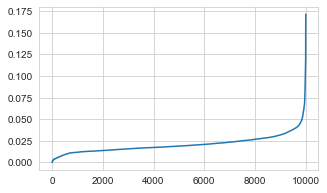

Text(0, 0.5, 'Rotational speed [rpm]')

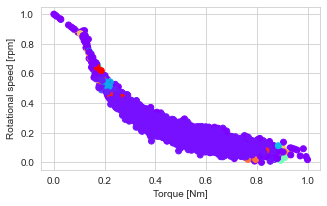

In [497]:
#identifying the potential value of epsilon
clustering_dataset = workingDataSet[["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]"]]


from sklearn.neighbors import NearestNeighbors # importing the library
neighbors = NearestNeighbors(n_neighbors=2) 
neighbor_model=neighbors.fit(clustering_dataset) # fitting the data to the object
distances,indices=neighbor_model.kneighbors(clustering_dataset) # finding the nearest neighbours
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

from sklearn.cluster import DBSCAN
dbscan_clustering = DBSCAN(eps=0.05, min_samples=2).fit(clustering_dataset)
labels = dbscan_clustering.labels_
plt.scatter(clustering_dataset["Torque [Nm]"], clustering_dataset["Rotational speed [rpm]"], c = labels, cmap= "rainbow") # plotting the clusters

plt.xlabel("Torque [Nm]") # X-axis label
plt.ylabel("Rotational speed [rpm]") # Y-axis label